In [144]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [145]:
#Loading in Training Data
X_train = pd.read_csv("./X_train.csv")
y_train = pd.read_csv("./y_train.csv")

In [146]:
#Loading in Testing Data
X_test = pd.read_csv("./X_test.csv")
y_test = pd.read_csv("./y_test.csv")

In [151]:
X_train.columns.to_list()

['IUCR', 'Primary Type', 'Arrest', 'Domestic', 'FBI Code', 'Year']

In [148]:
#Dropping location related columns and description (caused feature explosion)
cols_to_drop = [
    "ID", "Case Number", "Date", "Block",
    "Beat", "District", "Ward", "Community Area", "Updated On", "Description"
]

X_train = X_train.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)

In [149]:
# Combine X and y
train = pd.concat([X_train, y_train], axis=1)

# Drop rows where y is missing
train = train.dropna(subset=['Location'])

# Split back
X_train = train.drop(columns=['Location'])
y_train = train['Location']

In [150]:
# Combine X and y
train = pd.concat([X_train, y_train], axis=1)

# Drop rows with missing values anywhere
train_clean = train.dropna()

# Split back into X and y
X_train_clean = train_clean.iloc[:, :-1]   # all but last column
y_train_clean = train_clean.iloc[:, -1]    # last column 

In [152]:
#Defining features for one hot encoding 
categorical_features = ["IUCR", "Primary Type", "FBI Code"]
numeric_features = ["Year"]
binary_features = ["Arrest", "Domestic"]   # already numeric (0/1)
allowed = categorical_features + numeric_features + binary_features
X_train = X_train[allowed].copy()
X_test  = X_test[allowed].copy()

In [154]:
all_model_features = categorical_features + numeric_features + binary_features

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"   # Do not keep other columns!
)

In [155]:
print(X_train.dtypes)


IUCR            object
Primary Type    object
FBI Code        object
Year             int64
Arrest            bool
Domestic          bool
dtype: object


In [158]:
import ast

y_train = y_train.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
y_test  = y_test.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [162]:
print(y_train.dtypes)


object


In [165]:
y_train

0         (41.993262276, -87.655487613)
1         (41.765452556, -87.628746189)
2          (41.939262335, -87.71335694)
4         (41.882389156, -87.624374606)
5         (41.895973623, -87.673255236)
                      ...              
959611    (41.776699204, -87.610281196)
959612    (41.778969503, -87.654486077)
959613    (41.893541578, -87.629701805)
959614    (41.935392776, -87.730844578)
959615    (41.713254861, -87.715379798)
Name: Location, Length: 946700, dtype: object

In [166]:
def convert_location_series(series):
    def parse_value(x):
        if isinstance(x, str):
            return ast.literal_eval(x)  # Convert string to tuple
        return x
    
    coords = series.apply(parse_value)
    df_coords = pd.DataFrame(coords.tolist(), columns=['Latitude', 'Longitude'], index=series.index)
    return df_coords

# Apply
y_train_clean = convert_location_series(y_train)

print(y_train_clean.head())


    Latitude  Longitude
0  41.993262 -87.655488
1  41.765453 -87.628746
2  41.939262 -87.713357
4  41.882389 -87.624375
5  41.895974 -87.673255


In [169]:
print(y_test.head())

    Latitude  Longitude
0  41.893281 -87.627552
1  41.895515 -87.710559
2  41.653746 -87.599938
3  42.012044 -87.663078
4  41.739101 -87.559069


In [170]:
from sklearn.model_selection import train_test_split
#Using this method because we cannot access test set
#Split training set into internal train/validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_clean, test_size=0.2, random_state=42
)


Training and Optimizing Elastic Net Regression

In [171]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("model", MultiOutputRegressor(ElasticNet(max_iter=5000)))
])

param_grid = {
    "model__estimator__alpha": [0.01, 0.1, 1.0],
    "model__estimator__l1_ratio": [0.1, 0.5, 0.9]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(X_train_sub, y_train_sub)

print("Best hyperparameters:", grid.best_params_)

# Evaluate on internal validation
y_val_pred = grid.predict(X_val)


Best hyperparameters: {'model__estimator__alpha': 0.01, 'model__estimator__l1_ratio': 0.1}


Training and Optimizing Ridge Regression 

In [173]:
from sklearn.linear_model import Ridge

# Base Ridge model
ridge_base = MultiOutputRegressor(Ridge(max_iter=5000))

# Pipeline
ridge_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", ridge_base)
])

# Hyperparameter grid
ridge_params = {
    "model__estimator__alpha": [0.01, 0.1, 1.0, 10.0]
}

# Grid search with cross-validation
ridge_grid = GridSearchCV(
    ridge_pipe, param_grid=ridge_params, cv=5,
    scoring="neg_mean_squared_error", n_jobs=-1
)

# Fit on internal training subset
ridge_grid.fit(X_train_sub, y_train_sub)

print("Best Ridge alpha:", ridge_grid.best_params_)



Best Ridge alpha: {'model__estimator__alpha': 10.0}


Training and Optimizing Lasso 

In [175]:
# Base Lasso model
lasso_base = MultiOutputRegressor(Lasso(max_iter=5000))

# Pipeline including preprocessing
lasso_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", lasso_base)
])

# Hyperparameter grid
lasso_params = {
    "model__estimator__alpha": [0.001, 0.01, 0.1, 1.0]
}

# Cross-validated grid search
lasso_grid = GridSearchCV(
    lasso_pipe, param_grid=lasso_params, cv=5,
    scoring="neg_mean_squared_error", n_jobs=-1
)

# Fit on internal training subset
lasso_grid.fit(X_train_sub, y_train_sub)

print("Best Lasso alpha:", lasso_grid.best_params_)


Best Lasso alpha: {'model__estimator__alpha': 0.001}


Comparing Models

In [177]:
#Define models with best hyperparameters
models = {
    "Ridge": MultiOutputRegressor(Ridge(alpha=10.0, max_iter=5000)),
    "Lasso": MultiOutputRegressor(Lasso(alpha=0.001, max_iter=5000)),
    "ElasticNet": MultiOutputRegressor(ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=5000))
}

#DataFrame to store metrics
results = pd.DataFrame(columns=[
    "Model", "MSE", "RMSE", "MAE", "Latitude RMSE", "Longitude RMSE"
])

for name, model in models.items():
    # Pipeline with preprocessing
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    # Fit on full training set
    pipe.fit(X_train, y_train_clean)
    
    # Predict on internal validation set
    y_val_pred = pipe.predict(X_val)
    
    # Overall metrics
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Metrics per coordinate
    lat_rmse = np.sqrt(mean_squared_error(y_val["Latitude"], y_val_pred[:, 0]))
    lon_rmse = np.sqrt(mean_squared_error(y_val["Longitude"], y_val_pred[:, 1]))
    
    # Store results
    results = pd.concat([results, pd.DataFrame({
        "Model": [name],
        "MSE": [mse],
        "RMSE": [rmse],
        "MAE": [mae],
        "Latitude RMSE": [lat_rmse],
        "Longitude RMSE": [lon_rmse],
        "R2": [r2]
    })], ignore_index=True)

print("Internal Validation Metrics Comparison:")
print(results)


Internal Validation Metrics Comparison:
        Model       MSE      RMSE       MAE  Latitude RMSE  Longitude RMSE  \
0       Ridge  0.005305  0.072833  0.059319       0.084625        0.058717   
1       Lasso  0.005465  0.073925  0.060795       0.085991        0.059459   
2  ElasticNet  0.005468  0.073944  0.060826       0.086024        0.059459   

         R2  
0  0.041084  
1  0.013356  
2  0.012982  


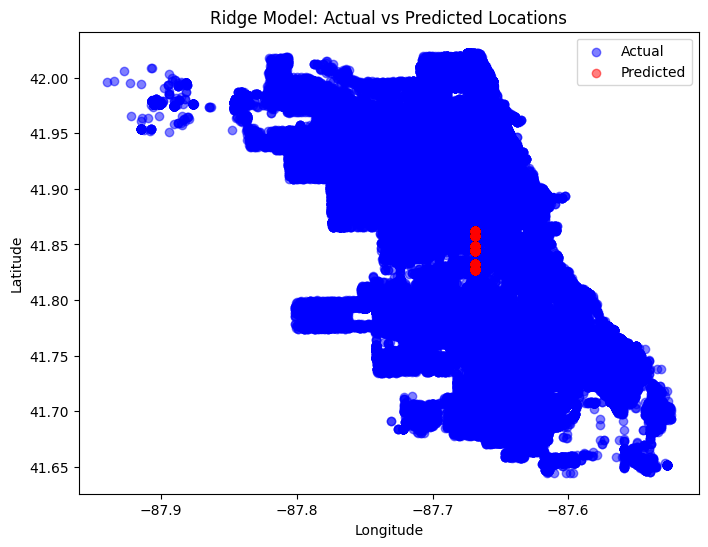

In [122]:
lat_actual = y_val["Latitude"]
lon_actual = y_val["Longitude"]

#Predicted coordinates
lat_pred = y_val_pred[:, 0]
lon_pred = y_val_pred[:, 1]

#Scatter plot for Latitude vs Longitude
plt.figure(figsize=(8, 6))
plt.scatter(lon_actual, lat_actual, color='blue', alpha=0.5, label='Actual')
plt.scatter(lon_pred, lat_pred, color='red', alpha=0.5, label='Predicted')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ridge Model: Actual vs Predicted Locations")
plt.legend()
plt.show()

In [181]:
#Retrain Ridge on full training data -- had best evaluation metrics
best_ridge_model = MultiOutputRegressor(Ridge(alpha=10.0, max_iter=5000))
ridge_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", best_ridge_model)
])

ridge_pipe.fit(X_train, y_train_clean)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_val_pred = ridge_pipe.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Ridge (final training) Validation Metrics:")
print("MSE:", mse, "RMSE:", rmse, "MAE:", mae, "R2:", r2)

Ridge (final training) Validation Metrics:
MSE: 0.005304579788846032 RMSE: 0.07283254621970889 MAE: 0.05931922810105427 R2: 0.04108402314522058
